In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import jax
import jax.numpy as jnp
import distrax
from functools import partial
from jax.scipy import stats
from jax.scipy.special import logsumexp

In [7]:
def get_dataloader(X,batch_size,key,axis=0):
    num_train=X.shape[axis]
    indices = jnp.array(list(range(0,num_train)))
    indices=jax.random.permutation(key,indices)
    for i in range(0, len(indices),batch_size):
        batch_indices = jnp.array(indices[i: i+batch_size])
        yield X[batch_indices]

def loglike_one_component(weight, mu, scale, data):
    return jnp.log(weight) + distrax.Normal(mu,scale).log_prob(data)

def loglike_across_components(weights, mus, scales, data):
    loglike_components = jax.vmap(partial(loglike_one_component,data=data))(
        weights, mus,scales
    )
    return logsumexp(loglike_components)

def log_likelihood(params, data):
    params['weights']=jax.nn.softmax(params['weights'])
    params['sigmas']=jax.vmap(jax.nn.softplus)(params['sigmas'])
    ll_per_data = jax.vmap(partial(loglike_across_components,params['weights'],params['mus'],params['sigmas']))(data)
    return -1.0*jnp.mean(ll_per_data)

def log_prior(params):
    log_prior=jax.tree_util.tree_map(lambda p: distrax.Normal(0.0,1.0).log_prob(p), params['mus']).sum()
    log_prior+=distrax.Dirichlet(jnp.ones(3)).log_prob(params['weights'])
    return log_prior

def log_post(params,batch):
    n_data=batch.shape[0]
    return -1.0/n_data*log_prior(params) + log_likelihood(params,batch)

In [8]:
grad_log_post=jax.jit(jax.grad(log_post))

#@partial(jax.jit, static_argnums=(3,4))
def sgld_kernel_momemtum(key, params, momemtum,grad_log_post, dt,batch):
    gamma,eps=0.9,1e-6
    key, subkey = jax.random.split(key, 2)
    grads = grad_log_post(params, batch)
    norm_grads=jax.tree_util.tree_map(lambda g: g/jnp.linalg.norm(g),grads)
    squared_grads=jax.tree_util.tree_map(lambda g: jnp.square(g),grads)
    momemtum=jax.tree_util.tree_map(lambda m,s : gamma*m+(1-gamma)*s,momemtum,squared_grads)
    noise=jax.tree_util.tree_map(lambda p: jax.random.normal(key=subkey,shape=p.shape), params)
    params=jax.tree_util.tree_map(lambda p, g,m,n: p-0.5*dt*g/(m+eps)+jnp.sqrt(dt)*n, params, grads,momemtum,noise)
    return key, params,momemtum

def sgld(key,log_post, grad_log_post, num_samples,
                             dt, x_0,X,batch_size):
    samples = list()
    loss=list()
    param = x_0
    key_data, key_model = jax.random.split(key, 2)
    schedule_fn = lambda k: dt * k ** (-0.55)
    momemtum=jax.tree_util.tree_map(lambda p:jnp.zeros_like(p),param)
    key_data_batch=jax.random.split(key_data, num_samples)
    for i in range(1,num_samples+1):
        train_data=get_dataloader(X,batch_size,key_data_batch[i])
        for _,X_batch in enumerate(train_data):
            key_model,param,momemtum = sgld_kernel_momemtum(key_model, param,momemtum, grad_log_post, dt, X_batch)
        loss.append(log_post(param,X_batch))
        samples.append(param)
        if (i%(num_samples//10)==0):
            print('iteration {0}, loss {1:.2f}'.format(i,loss[-1]))
    return samples,loss


In [12]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

k = 3
ndata = 500
centers = np.array([-5.0, 0.0, 5.0])
sds = np.array([0.5, 2.0, 0.75])
idx = rng.integers(0, k, ndata)
X = rng.normal(loc=centers[idx], scale=sds[idx], size=ndata)

key=jax.random.PRNGKey(RANDOM_SEED)
key_model,key_data=jax.random.split(key,2)
key_mu,key_sigma=jax.random.split(key_model,2)
params={'weights':jnp.ones(3)/3.,
        'mus':jax.random.normal(key_mu,shape=(3,)),
        'sigmas':jax.random.normal(key_sigma,shape=(3,))}
samples,loss=sgld(key_data,log_post, grad_log_post, 5_000,1e-2,params,X,256)

posterior_means=jnp.stack([s['mus'] for s in samples])
posterior_weights=jnp.stack([s['weights'] for s in samples])
posterior_sigmas=jnp.stack([s['sigmas'] for s in samples])

iteration 500, loss 2.71
iteration 1000, loss 2.69
iteration 1500, loss 2.75
iteration 2000, loss 2.71
iteration 2500, loss nan
iteration 3000, loss nan
iteration 3500, loss nan
iteration 4000, loss nan
iteration 4500, loss nan
iteration 5000, loss 2.72


In [14]:
jnp.median(posterior_means,axis=0)

Array([ 0.01772566, -4.0599813 ,  4.1311407 ], dtype=float32)

In [15]:
np.save('data/posterior_means',np.asarray(posterior_means))
np.save('data/posterior_weights',np.asarray(posterior_weights))
np.save('data/posterior_sigmas',np.asarray(posterior_sigmas))


In [16]:
def quantization(x, s, z, alpha_q, beta_q):
    x_q = np.round(1 / s * x + z, decimals=0)
    x_q = np.clip(x_q, a_min=alpha_q, a_max=beta_q)
    return x_q


def quantization_int8(x, s, z):
    x_q = quantization(x, s, z, alpha_q=-128, beta_q=127)
    x_q = x_q.astype(np.int8)
    return x_q

def dequantization(x_q, s, z):
    # x_q - z might go outside the quantization range.
    x_q = x_q.astype(np.int32)
    x = s * (x_q - z)
    x = x.astype(np.float64)
    return x


def generate_quantization_constants(alpha, beta, alpha_q, beta_q):
    # Affine quantization mapping
    s = (beta - alpha) / (beta_q - alpha_q)
    z = int((beta * alpha_q - alpha * beta_q) / (beta - alpha))
    return s, z


def generate_quantization_int8_constants(alpha, beta):
    b = 8
    alpha_q = -2**(b - 1)
    beta_q = 2**(b - 1) - 1
    s, z = generate_quantization_constants(alpha=alpha,
                                           beta=beta,
                                           alpha_q=alpha_q,
                                           beta_q=beta_q)
    return s, z

In [18]:

def quantize_samples(samples):
    s=list()
    z=list()
    q_samples=np.zeros_like(samples).astype(np.int8)
    for i in range(samples.shape[0]):
        alpha=np.min(samples[i,:])
        beta=np.max(samples[i,:])
        ss,zz=generate_quantization_int8_constants(alpha,beta)
        x_q=quantization_int8(samples[i,:],ss,zz)
        q_samples[i,:]=x_q
        s.append(ss)
        z.append(zz)
    return q_samples,s,z

def dequantizate_samples(q_samples,s,z):
    samples=np.zeros_like(q_samples).astype(np.float16)
    for i in range(q_samples.shape[0]):
        samples[i,:]=dequantization(q_samples[i,:], s[i], z[i])
    return samples

In [19]:
posterior_means=np.asarray(posterior_means)
posterior_weights=np.asarray(posterior_weights)
posterior_sigmas=np.asarray(posterior_sigmas)

In [20]:
q_means,s,z=quantize_samples(posterior_means)
r_means=dequantizate_samples(q_means,s,z)

q_weights,s,z=quantize_samples(posterior_weights)
r_weights=dequantizate_samples(q_means,s,z)

q_sigmas,s,z=quantize_samples(posterior_sigmas)
r_sigmas=dequantizate_samples(q_sigmas,s,z)

In [27]:
from scipy.stats import norm

mus=np.median(posterior_means,axis=0)
sigmas=np.median(posterior_sigmas,axis=0)
weights=np.median(posterior_weights,axis=0)

x = np.linspace(X.min(), X.max(), 1000)
y0 = weights[0]*norm.pdf(x, mus[0], np.sqrt(sigmas[0]))
y1 = weights[1]*norm.pdf(x, mus[1], np.sqrt(sigmas[1]))
y2 = weights[2]*norm.pdf(x, mus[2], np.sqrt(sigmas[2]))

Text(0.5, 1.0, 'SG-MCMC Posterior Samples')

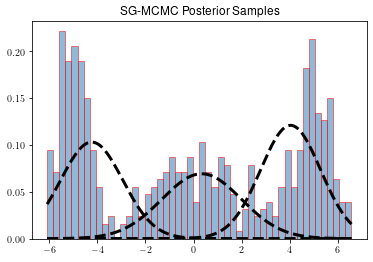

In [28]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)


plt.hist(X, bins=50, density=True, ec='red', alpha=0.5);
plt.plot(x,y0,'--',c='black',lw=3)
plt.plot(x,y1,'--',c='black',lw=3)
plt.plot(x,y2,'--',c='black',lw=3)
plt.title('SG-MCMC Posterior Samples')

In [29]:
mus=np.median(r_means,axis=0)
sigmas=np.median(r_sigmas,axis=0)
weights=np.median(r_weights,axis=0)

x = np.linspace(X.min(), X.max(), 1000)
y0 = weights[0]*norm.pdf(x, mus[0], np.sqrt(sigmas[0]))
y1 = weights[1]*norm.pdf(x, mus[1], np.sqrt(sigmas[1]))
y2 = weights[2]*norm.pdf(x, mus[2], np.sqrt(sigmas[2]))

Text(0.5, 1.0, 'SG-MCMC Quantized Posterior Samples')

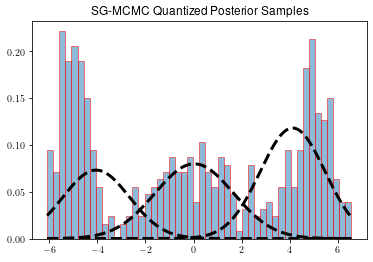

In [30]:
plt.hist(X, bins=50, density=True, ec='red', alpha=0.5);
plt.plot(x,y0,'--',c='black',lw=3)
plt.plot(x,y1,'--',c='black',lw=3)
plt.plot(x,y2,'--',c='black',lw=3)
plt.title('SG-MCMC Quantized Posterior Samples')

In [33]:
grads=[grad_log_post(s,X) for s in samples]
grad_means=jnp.stack([g['mus'] for g in grads])
grad_weights=jnp.stack([g['weights'] for g in grads])
grad_sigmas=jnp.stack([g['sigmas'] for g in grads])

In [39]:
from stein_thinning.stein import ksd, kmat
from stein_thinning.thinning import thin
from stein_thinning.kernel import make_imq, make_precon

idx_means = thin(posterior_means, grad_means, 1000)
idx_sigmas = thin(posterior_sigmas, grad_sigmas, 1000)
idx_weights = thin(posterior_weights, grad_weights, 1000)

mus=np.median(posterior_means[idx_means],axis=0)
sigmas=np.median(posterior_sigmas[idx_sigmas],axis=0)
weights=np.median(posterior_weights[idx_weights],axis=0)

x = np.linspace(X.min(), X.max(), 1000)
y0 = weights[0]*norm.pdf(x, mus[0], np.sqrt(sigmas[0]))
y1 = weights[1]*norm.pdf(x, mus[1], np.sqrt(sigmas[1]))
y2 = weights[2]*norm.pdf(x, mus[2], np.sqrt(sigmas[2]))


Text(0.5, 1.0, 'SG-MCMC Stein Thinned Posterior Samples')

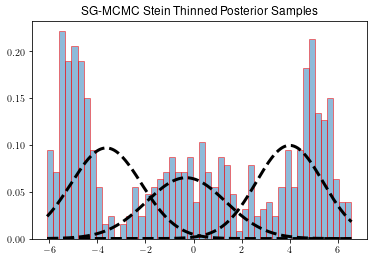

In [40]:
plt.hist(X, bins=50, density=True, ec='red', alpha=0.5);
plt.plot(x,y0,'--',c='black',lw=3)
plt.plot(x,y1,'--',c='black',lw=3)
plt.plot(x,y2,'--',c='black',lw=3)
plt.title('SG-MCMC Stein Thinned Posterior Samples')

In [42]:
q_means.nbytes

15000

In [43]:
posterior_means.nbytes

60000

In [44]:
posterior_means[idx_means].nbytes

12000